In [1]:
#!/usr/bin/env python
# coding: utf-8
import re
import sys
import pandas as pd
import sys
import ast
import matplotlib.pyplot as plt
import os
import time

global _app_name
run_command="/opt/jdk-14/bin/java -Dfile.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/out/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/json-simple-1.1.1.jar org.fog.test.perfeval."
_app_name="TwoDCNSApps"
_app_name="HighResDCNS"
_report_path="Report_Saeedeh/t_pandas.txt"
_save_path="Report_Saeedeh/Pandas"


In [2]:
def run(app_name="TwoDCNSApps", scenario="Router_Proxy", report_path=_report_path): 
    #cmd=f'{run_command}{app_name} {scenario} | tee -a {report_path} >/dev/null'
    cmd=f'{run_command}{app_name} {scenario} 2>&1 >> {report_path}'
    os.system(cmd)

In [3]:
# init
global Scenario,Resolution,app_class,data_frames
Scenario=None
Resolution=None
app_class=None
data_frames=None



# Initialize and maintain other DataFrames as global variables
if 'computation_energy_per_vm_df' not in globals():
    computation_energy_per_vm_df = pd.DataFrame(columns=['app_class','scenario','device', 'app', 'vm', 'energy'])

if 'computation_energy_df' not in globals():
    computation_energy_df = pd.DataFrame(columns=['app_class','scenario','device', 'energy'])

if 'communication_energy_df' not in globals():
    communication_energy_df = pd.DataFrame(columns=['app_class','scenario','device_id', 'device', 'tuple', 'energy'])

#if 'execution_time_df' not in globals():
#    execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
if 'loop_delay_df' not in globals():
    loop_delay_df = pd.DataFrame(columns=['app_class','scenario','app','loop_name', 'delay'])
    
if 'loop_count_delay_df' not in globals():
    loop_count_delay_df = pd.DataFrame(columns=['Resolution','loop_count','loop_delay'])
    
if 'simulation_time_df' not in globals():
    simulation_time_df = pd.DataFrame(columns=['app_class','scenario', 'simulation_time'])

In [4]:
# reset: remove report and clear dfs
def _reset():
    #os.system(f'rm {_report_path}')
    computation_energy_per_vm_df = pd.DataFrame(columns=['app_class','scenario','device', 'app', 'vm', 'energy'])
    computation_energy_df = pd.DataFrame(columns=['app_class','scenario','device', 'energy'])
    communication_energy_df = pd.DataFrame(columns=['app_class','scenario','device_id', 'device', 'tuple', 'energy'])
    #execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
    loop_delay_df = pd.DataFrame(columns=['app_class','scenario','app','loop_name', 'delay'])
    loop_count_delay_df=pd.DataFrame(columns=['Resolution','loop_count','loop_delay'])
    simulation_time_df = pd.DataFrame(columns=['app_class','scenario', 'simulation_time'])
    time.sleep(3)

In [5]:
# Parsing Functions
# string map to map
def parse_map_string(sample):
    # Use regex to convert the string into a valid JSON format
    formatted_sample = re.sub(r'(\w+)=', r'"\1":', sample)
    formatted_sample = re.sub(r'(\w+)(?==)', r'"\1"', formatted_sample)

    # Parse the formatted string into a dictionary
    parsed_sample = ast.literal_eval(formatted_sample)

    #print(parsed_sample)
    return parsed_sample

# For this format:
def parse_vm_energy(l):
    global computation_energy_per_vm_df
    #l="cloud : Vms Energy Map of device : cloud {dcns_1={user_interface_1=12823.499999997002}, dcns_0={user_interface=13373.078571425585}}"
    pattern = r'^(.*?): Vms Energy Map of device : (.*?) ({.*?})$'  # Adjusted pattern
    # Match the pattern with the line
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        m=match.group(3)
        apps_vms_energy_map=parse_map_string(m)
        for app in apps_vms_energy_map:
            for vm in apps_vms_energy_map[app]:
                data={'scenario':Scenario, 'device':device,'app':app,'vm':vm, 'energy':apps_vms_energy_map[app][vm]}
                df=pd.DataFrame([data])
                df['app_class']=app_class
                computation_energy_per_vm_df=pd.concat([computation_energy_per_vm_df,df], ignore_index=True)



def parse_device_total_energy(l):
    global computation_energy_df
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^(.*?): Energy Consumed = (\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        device=match.group(1)
        device_energy=float(match.group(2))
        data={'scenario':Scenario, 'device':device, 'energy':device_energy}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        computation_energy_df=pd.concat([computation_energy_df,df],ignore_index=True)

        
def parse_scenario(l):
    global Scenario
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Scenario (.*?)$'
    match = re.match(pattern, l)
    if match:
        Scenario=match.group(1)
        print(f"\n\n\n*******************************************\nScenario is {Scenario}\n*******************************************")

def parse_resolution(l):
    global Resolution
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Resolution is (\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        Resolution=float(match.group(1))
        Resolution = round(Resolution, 1)  # Round to one digit after the point
        print(f"\n\n\n*******************************************\nResolution is {Resolution}\n*******************************************")

        
def parse_app_class(l):
    global app_class
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Starting (.*?)...$'
    match = re.match(pattern, l)
    if match:
        app_class=match.group(1)
        print(f"\n\n\n####################################\napp_class is {app_class}\n###################################")



def parse_tuple_networking_energy(l):
    global communication_energy_df
    #l="6 d-0 Networking Tuples energy Map {dcns_1={MOTION_VIDEO_STREAM_1=134177.01818170713, PTZ_PARAMS_1=3143.6363636335045}, dcns_0={PTZ_PARAMS=3143.636363633739, DETECTED_OBJECT=6943.299999994468}}"
    pattern = r'^(\d+)\s+(\S+)\s+Networking Tuples energy Map\s+({.*})$'
    match = re.match(pattern, l)
    if match:
        device_id=match.group(1)
        device_name=match.group(2)
        m=match.group(3)
        apps_tuples_energy_map=parse_map_string(m)
        for app in apps_tuples_energy_map:
            for tuple_name in apps_tuples_energy_map[app]:
                data={'scenario':Scenario, 'device_id':device_id,'device':device_name,'app':app,'tuple':tuple_name, 'energy':apps_tuples_energy_map[app][tuple_name]}
                df=pd.DataFrame([data])
                df['app_class']=app_class
                communication_energy_df=pd.concat([communication_energy_df,df], ignore_index=True)



# For Tuple execution time
def parse_tuple_execution_time(l):
    global execution_time_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    pattern = r'^(.*?)\s+--->=\s+(\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        tuple_name=match.group(1)
        execution_time=float(match.group(2))
        data={'scenario':Scenario, 'tuple':tuple_name,'execution_time':execution_time}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        display(df)
        execution_time_df=pd.concat([execution_time_df,df],ignore_index=True)



# For loop delay
def parse_loops_delay(l):
    global loop_delay_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    #pattern = r'^(.*?) ([.*?])\s+--->=\s+(\d+(\.\d+)?)$'
    pattern = r'^(\S+)\s+\[(.*?)\]\s+--->=\s+(\d+\.\d+)$'

    match = re.match(pattern, l)
    if match:
        app_name=match.group(1)
        loop_name=match.group(2)
        loop_name=f'[{loop_name}]'
        loop_delay=float(match.group(3))
        data={'scenario':Scenario, 'app':app_name, 'loop_name':loop_name,'delay':loop_delay}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        display(df)
        loop_delay_df=pd.concat([loop_delay_df,df],ignore_index=True)

        
#


def parse_Loop_Count_Delay(l):
    global loop_count_delay_df
    
    # Define the pattern to extract resolution, loop count, and delay
    pattern = r'Loop count is (\d+) and delay is (\d+(\.\d+)?)  and emit time is (\d+(\.\d+)?) and completion time is (\d+(\.\d+)?)'
    
    # Search for the pattern in the input string 'l'
    match = re.search(pattern, l)
    if match:
        loop_count = int(match.group(1))
        loop_delay = float(match.group(2))
        emit_time = float(match.group(3))
        completion_time = float(match.group(4))
        
        # Create a dictionary to store the data
        data = {'Resolution': float(Resolution), 'loop_count': loop_count, 'loop_delay': loop_delay, 'emit_time': emit_time, 'completion_time': completion_time}
        
        # Create a DataFrame from the dictionary
        df = pd.DataFrame([data])
        
        # Concatenate the new DataFrame with the existing loop_count_delay_df
        loop_count_delay_df = pd.concat([loop_count_delay_df, df], ignore_index=True)



# For total simulation time
def parse_simulation_time(l):
    #l="EXECUTION TIME = 370"
    pattern = r'^EXECUTION TIME = (\d+(\.\d+)?)$'
    global simulation_time_df
    match = re.match(pattern, l)
    if match:
        exec_time=match.group(1)
        data={'scenario':Scenario, 'simulation_time':exec_time}
        df=pd.DataFrame([data])
        df['app_class']=app_class
        simulation_time_df=pd.concat([simulation_time_df,df],ignore_index=True)

In [6]:
#line='dcns_0 [motion_detector, object_detector, object_tracker] --->= 1259.001302362737'
#parse_loops_delay(line)

In [7]:
# Parse
def parse(report_path=_report_path):
    with open(report_path, 'r') as file:
        for l in file:
            parse_app_class(l)
            parse_scenario(l)
            parse_vm_energy(l)
            parse_device_total_energy(l)
            parse_tuple_networking_energy(l)
            #parse_tuple_execution_time(l)
            parse_loops_delay(l)
            parse_Loop_Count_Delay(l)
            parse_resolution(l)
            parse_simulation_time(l)
        

In [8]:
def save(save_path=_save_path):
    global data_frames
    # Combine all DataFrames
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        #'Execution Time': execution_time_df,
        'Loop Delay': loop_delay_df,
        'loop Count Delay': loop_count_delay_df,
        'Simulation Time': simulation_time_df
    }
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.to_csv(f"{save_path}/{name}.csv", index=False)

In [9]:
def sort_scenarios():
    global data_frames
    # Combine all DataFrames
    computation_energy_per_vm_df['energy']=computation_energy_per_vm_df['energy']/1000
    #computation_energy_df['energy']=computation_energy_df['energy']/1000
    communication_energy_df['energy']=communication_energy_df['energy']/1000
    data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        #'Execution Time': execution_time_df,
        'Loop Delay': loop_delay_df,
        'Simulation Time': simulation_time_df
    }
    for key in data_frames:
        df = data_frames[key]
        # Create a categorical Series for the 'scenario' column
        df['scenario'] = pd.Categorical(df['scenario'], categories=scenarios_list, ordered=True)
        
        # Sort the DataFrame based on the specified order
        df_sorted = df.sort_values(by=['scenario'])
        # Update the DataFrame in the dictionary
        data_frames[key] = df_sorted

In [10]:
def load(save_path=_save_path):
    global data_frames
    global computation_energy_per_vm_df,computation_energy_df,communication_energy_df,execution_time_df,simulation_time_df
    # Combine all DataFrames
    '''data_frames = {
        'Computation Energy VMs': computation_energy_per_vm_df,
        'Computation Energy Devices': computation_energy_df,
        'Communication Energy': communication_energy_df,
        'Execution Time': execution_time_df,
        'Simulation Time': simulation_time_df
    }'''
    # Save each DataFrame to a separate CSV file
    for name, df in data_frames.items():
        df.read_csv(f"{save_path}/{name}.csv", index=False)
    computation_energy_per_vm_df=data_frames['Computation Energy VMs']
    computation_energy_df=data_frames['Computation Energy Devices']
    communication_energy_df=data_frames['Communication Energy']
    #execution_time_df=data_frames['Execution Time']
    loop_delay_df=data_frames['Loop Delay']
    simulation_time_df=data_frames['Simulation Time']

In [11]:
_load=False
if _load:
    _reset()
    load()

In [12]:

run1=True
scenarios_list=[ 'Router_Only','Router_Proxy','Router_Cloud','Proxy_Only','Proxy_Cloud','Cloud_Only','ModuleBased_Router_Proxy']
if run1:
    _reset()
    for scenario in scenarios_list:
        run("TwoDCNSApps", scenario)
        run("HighResTwoDCNSApp", scenario)
        run("LowResTwoDCNSApp", scenario)


In [13]:
# Experiment for loop delay and count for each resolution
run2=False
if run2:
    _reset()
    for i in range(1,51):
        res=i*0.1
        run("HighResDCNS",res)

In [14]:
# Parse the results
_reset()
parse()
sort_scenarios()
save()





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",4.604762,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",4.604762,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",6.909524,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",6.909524,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[motion_detector, object_detector, object_trac...",3.452381,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",3.15,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",3.452381,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",3.11,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",3.452381,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.732381,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",4.604762,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",7.164762,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",2.87619,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.01619,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",3.452381,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.69872,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",4.604762,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.185,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Router_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",2.87619,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",3.11,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.46186,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Router_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",6.684762,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",6.684762,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",9.069524,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",9.069524,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[motion_detector, object_detector, object_trac...",5.492381,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.492381,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",5.532381,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.69872,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",6.764762,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.185,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Proxy_Cloud
*******************************************


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[motion_detector, object_detector, object_trac...",4.91619,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_0,"[object_tracker, PTZ_CONTROL]",5.111,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.46186,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Proxy_Cloud,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.151,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.495802,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.743301,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.785,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",105.193906,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is Cloud_Only
*******************************************


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[motion_detector, object_detector, object_trac...",104.36,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_0,"[object_tracker, PTZ_CONTROL]",105.152,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[motion_detector_1, object_detector_1, object_...",104.480518,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,Cloud_Only,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",105.112,LowResTwoDCNSApps





####################################
app_class is TwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",6.608249,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",6.616198,TwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,TwoDCNSApps





####################################
app_class is HighResTwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",8.914014,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",8.925973,HighResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,HighResTwoDCNSApps





####################################
app_class is LowResTwoDCNSApps
###################################



*******************************************
Scenario is ModuleBased_Router_Proxy
*******************************************


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[motion_detector, object_detector, object_trac...",5.455376,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_0,"[object_tracker, PTZ_CONTROL]",5.151,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[motion_detector_1, object_detector_1, object_...",5.461356,LowResTwoDCNSApps


,scenario,app,loop_name,delay,app_class
0,ModuleBased_Router_Proxy,dcns_1,"[object_tracker_1, PTZ_CONTROL_1]",5.111,LowResTwoDCNSApps


In [15]:
# rearange 
t=computation_energy_per_vm_df
t=t.pivot_table(index=['scenario','app_class','app'],columns=['vm'],values='energy',aggfunc='sum')
#t.reset_index(inplace=True)
#t=t.reindex(columns=scenarios_list)
t=t.transpose()
display(t)
t.to_csv("jj.csv")




scenario                 Router_Only                                           
app_class         HighResTwoDCNSApps            LowResTwoDCNSApps              
app                           dcns_0     dcns_1            dcns_0     dcns_1   
vm                                                                             
motion_detector            95.413535   0.000000         26.439895   0.000000  \
motion_detector_1           0.000000  95.413535          0.000000  26.439895   
object_detector            49.583462   0.000000         13.241288   0.000000   
object_detector_1           0.000000  41.125149          0.000000  11.126710   
object_tracker             11.070229   0.000000         11.126710   0.000000   
object_tracker_1            0.000000  11.070229          0.000000  11.126710   
user_interface              2.504960   0.000000          0.626240   0.000000   
user_interface_1            0.000000   4.223392          0.000000   5.752648   

scenario                                       Router_Proxy              
app_class         TwoDCNSApps            HighResTwoDCNSApps              
app                    dcns_0     dcns_1             dcns_0     dcns_1   
vm                                                                       
motion_detector     39.394335   0.000000          95.413535   0.000000  \
motion_detector_1    0.000000  39.394335           0.000000  95.413535   
object_detector     20.262792   0.000000          42.392260   0.000000   
object_detector_1    0.000000  16.892347           0.000000  44.714565   
object_tracker       8.867479   0.000000          12.183999   0.000000   
object_tracker_1     0.000000   8.867479           0.000000  12.122151   
user_interface       0.988800   0.000000           6.728352   0.000000   
user_interface_1     0.000000   4.139129           0.000000   6.728352   

scenario                                        ...        Cloud_Only   
app_class         LowResTwoDCNSApps             ... LowResTwoDCNSApps   
app                          dcns_0     dcns_1  ...            dcns_0   
vm                                              ...                     
motion_detector           26.439895   0.000000  ...         26.439895  \
motion_detector_1          0.000000  26.439895  ...          0.000000   
object_detector           12.183999   0.000000  ...         31.641600   
object_detector_1          0.000000  12.818372  ...          0.000000   
object_tracker            12.183999   0.000000  ...          0.628349   
object_tracker_1           0.000000  12.183999  ...          0.000000   
user_interface             6.378888   0.000000  ...          0.016480   
user_interface_1           0.000000   6.378888  ...          0.000000   

scenario                                            ModuleBased_Router_Proxy   
app_class                    TwoDCNSApps                  HighResTwoDCNSApps   
app                   dcns_1      dcns_0     dcns_1                   dcns_0   
vm                                                                             
motion_detector     0.000000   39.394335   0.000000                95.413535  \
motion_detector_1  26.439895    0.000000  39.394335                 0.000000   
object_detector     0.000000   26.023686   0.000000                49.583462   
object_detector_1   0.490182    0.000000  15.093555                 0.000000   
object_tracker      0.000000    2.847149   0.000000                11.437114   
object_tracker_1   22.017035    0.000000  22.499124                 0.000000   
user_interface      0.000000    0.352097   0.000000                 2.755456   
user_interface_1    0.000000    0.000000   0.000000                 0.000000   

scenario                                                                
app_class                    LowResTwoDCNSApps            TwoDCNSApps   
app                   dcns_1            dcns_0     dcns_1      dcns_0   
vm                                                                      
motion_detector     

In [16]:
computation_energy_per_vm_df.query("app_class=='HighResTwoDCNSApps' and app=='dcns_1' and vm=='object_detector_1'")

,app_class,scenario,device,app,vm,energy
17,HighResTwoDCNSApps,Router_Only,d-0,dcns_1,object_detector_1,41.125149
59,HighResTwoDCNSApps,Router_Proxy,proxy-server,dcns_1,object_detector_1,44.714565
100,HighResTwoDCNSApps,Router_Cloud,cloud,dcns_1,object_detector_1,39.255360
143,HighResTwoDCNSApps,Proxy_Only,proxy-server,dcns_1,object_detector_1,42.393896
184,HighResTwoDCNSApps,Proxy_Cloud,cloud,dcns_1,object_detector_1,39.255360
226,HighResTwoDCNSApps,Cloud_Only,cloud,dcns_1,object_detector_1,41.309867
270,HighResTwoDCNSApps,ModuleBased_Router_Proxy,d-0,dcns_1,object_detector_1,41.125149


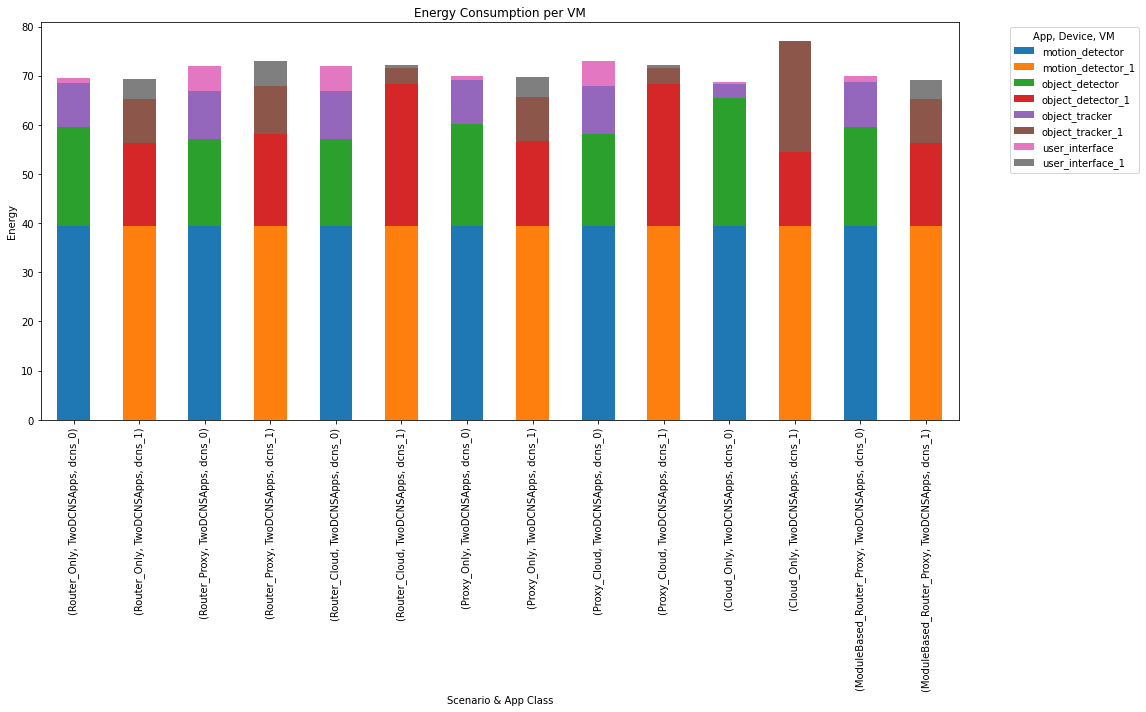

In [17]:
#VM computation Energy for twodcns(figure edge2024)
t=computation_energy_per_vm_df
t=t.query("app_class=='TwoDCNSApps'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['scenario','app_class', 'app'],columns=['vm'],values='energy',aggfunc='sum')
#display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Energy Consumption per VM")
ax.set_xlabel("Scenario & App Class")
ax.set_ylabel("Energy")
ax.legend(title='App, Device, VM', bbox_to_anchor=(1.05, 1), loc='upper left')


hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_idx = 0
for patch in ax.patches:
    if hatch_idx >= len(hatch_patterns):
        hatch_idx = 0
    if patch.get_label().startswith('app_1'):
        patch.set_hatch(hatch_patterns[hatch_idx])
        hatch_idx += 1


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


       app_class    scenario device_id        device                  tuple   
234  TwoDCNSApps  Cloud_Only         4         cloud           PTZ_PARAMS_1  \
236  TwoDCNSApps  Cloud_Only         5  proxy-server  MOTION_VIDEO_STREAM_1   
237  TwoDCNSApps  Cloud_Only         5  proxy-server           PTZ_PARAMS_1   
240  TwoDCNSApps  Cloud_Only         6           d-0  MOTION_VIDEO_STREAM_1   
241  TwoDCNSApps  Cloud_Only         6           d-0           PTZ_PARAMS_1   
244  TwoDCNSApps  Cloud_Only         7         m-0-0  MOTION_VIDEO_STREAM_1   
246  TwoDCNSApps  Cloud_Only         8         m-0-1  MOTION_VIDEO_STREAM_1   
248  TwoDCNSApps  Cloud_Only         9         m-0-2  MOTION_VIDEO_STREAM_1   
250  TwoDCNSApps  Cloud_Only        10         m-0-3  MOTION_VIDEO_STREAM_1   

        energy     app  
234   0.479652  dcns_1  
236  54.290600  dcns_1  
237   0.164255  dcns_1  
240  56.628473  dcns_1  
241   6.287273  dcns_1  
244   5.655960  dcns_1  
246   5.655960  dcns_1  
248   5.6

tuple                                        MOTION_VIDEO_STREAM   
scenario                 app_class   app                           
Router_Only              TwoDCNSApps dcns_0            22.623842  \
                                     dcns_1             0.000000   
Router_Proxy             TwoDCNSApps dcns_0            22.623842   
                                     dcns_1             0.000000   
Router_Cloud             TwoDCNSApps dcns_0            22.623842   
                                     dcns_1             0.000000   
Proxy_Only               TwoDCNSApps dcns_0            79.252314   
                                     dcns_1             0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0            79.252314   
                                     dcns_1             0.000000   
Cloud_Only               TwoDCNSApps dcns_0           133.542914   
                                     dcns_1             0.000000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0            22.623842   
                                     dcns_1             0.000000   

tuple                                        MOTION_VIDEO_STREAM_1   
scenario                 app_class   app                             
Router_Only              TwoDCNSApps dcns_0               0.000000  \
                                     dcns_1              22.623842   
Router_Proxy             TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              79.252314   
Router_Cloud             TwoDCNSApps dcns_0               0.000000   
                                     dcns_1             133.542914   
Proxy_Only               TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              79.252314   
Proxy_Cloud              TwoDCNSApps dcns_0               0.000000   
                                     dcns_1             133.542914   
Cloud_Only               TwoDCNSApps dcns_0               0.000000   
                                     dcns_1             133.542914   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0               0.000000   
                                     dcns_1              22.623842   

tuple                                        OBJECT_LOCATION   
scenario                 app_class   app                       
Router_Only              TwoDCNSApps dcns_0         0.000000  \
                                     dcns_1         0.000000   
Router_Proxy             TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Router_Cloud             TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Proxy_Only               TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
Cloud_Only               TwoDCNSApps dcns_0         0.000000   
                                     dcns_1         0.000000   
ModuleBased_Router_Proxy TwoDCNSApps dcns_0         2.831424   
                                     dcns_1         0.000000   

tuple                                        OBJECT_LOCATION_1   
scenario                 app_class   app                         
Router_Only              TwoDCNSApps dcns_0           0.000000  \
                                     dcns_1           0.000000   
Router_Proxy             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Router_Cloud             TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Proxy_Only               TwoDCNSApps dcns_0           0.000000   
                                     dcns_1           0.000000   
Proxy_Cloud              TwoDCNSApps dcns_0           0.000000   
                                     dc

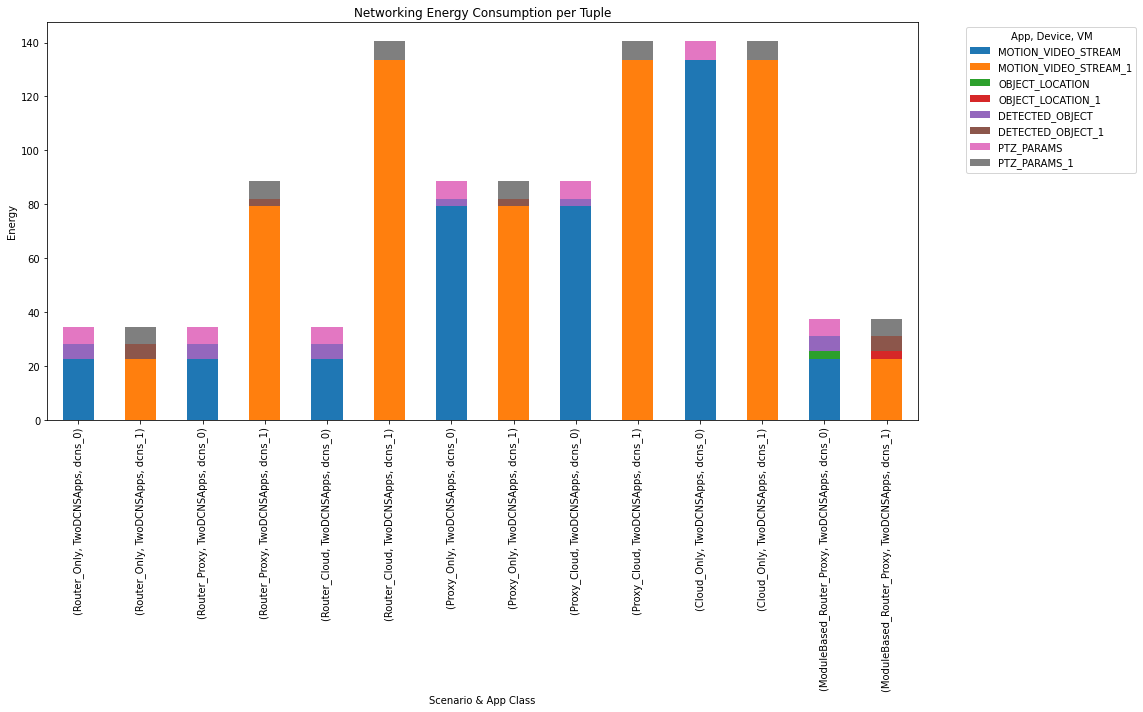

In [18]:
# Comunication energy for twodcns
t=communication_energy_df
#display(t)
t=t.query("app_class in ['TwoDCNSApps']")
#t['energy']=t['energy']/1000

print(t.query("scenario == 'Cloud_Only' and app=='dcns_1'"))

pivot_df = t.pivot_table(index=['scenario','app_class','app'],columns=['tuple'],values='energy',aggfunc='sum')
pivot_df=pivot_df.reindex(columns=['MOTION_VIDEO_STREAM','MOTION_VIDEO_STREAM_1','OBJECT_LOCATION','OBJECT_LOCATION_1','DETECTED_OBJECT','DETECTED_OBJECT_1','PTZ_PARAMS','PTZ_PARAMS_1'])
display(pivot_df)
pivot_df.to_csv('inobebin.csv')
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Networking Energy Consumption per Tuple")
ax.set_xlabel("Scenario & App Class")
ax.set_ylabel("Energy")
ax.legend(title='App, Device, VM', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

vm                                                  motion_detector   
scenario                 app_class          app                       
Router_Only              HighResTwoDCNSApps dcns_0        95.413535  \
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
Router_Proxy             HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
Router_Cloud             HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
Proxy_Only               HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
Proxy_Cloud              HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
Cloud_Only               HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   
ModuleBased_Router_Proxy HighResTwoDCNSApps dcns_0        95.413535   
                                            dcns_1         0.000000   
                         LowResTwoDCNSApps  dcns_0        26.439895   
                                            dcns_1         0.000000   
                         TwoDCNSApps        dcns_0        39.394335   
                                            dcns_1         0.000000   

vm                                                  motion_detector_1   
scenario                 app_class          app                         
Router_Only              HighResTwoDCNSApps dcns_0           0.000000  \
                                            dcns_1          95.413535   
                         LowResTwoDCNSApps  dcns_0           0.000000   
                                            dcns_1          26.439895   
                         TwoDCNSApps        dcns_0           0.000000   
                                            dcns_1          39.394335   
Router_Proxy             HighResTwoDCNSApps dcns_0           0.000000   
                                            dcns_1          95.413535   
                         LowResTwoDCNSApps  dcns_0           0.000000   
                                            dcns_1          26.439895   

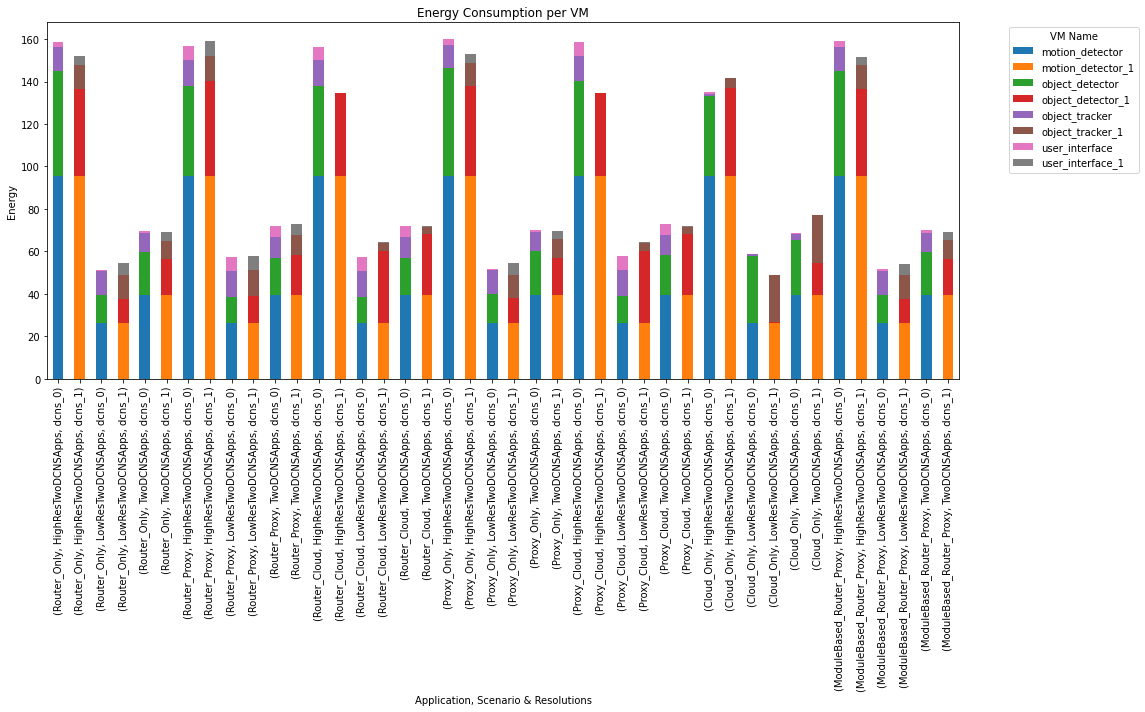

In [19]:

#VM computation Energy for all resolutions(figure edge2024)
t=computation_energy_per_vm_df
#t=t.query("app=='dcns_0'")
#t=t.query("app_class=='TwoDCNSApps'")
#t=t.query("scenario =='Router_Only'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['scenario','app_class','app'],columns=['vm'],values='energy',aggfunc='sum')
display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Energy Consumption per VM")
ax.set_xlabel("Application, Scenario & Resolutions")
ax.set_ylabel("Energy")
ax.legend(title='VM Name', bbox_to_anchor=(1.05, 1), loc='upper left')


hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_idx = 0
for patch in ax.patches:
    if hatch_idx >= len(hatch_patterns):
        hatch_idx = 0
    if patch.get_label().startswith('app_1'):
        patch.set_hatch(hatch_patterns[hatch_idx])
        hatch_idx += 1


# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
plt.savefig('Report_Saeedeh/Pandas/App_VMs_Computation_Energy_Chart_Fig.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()


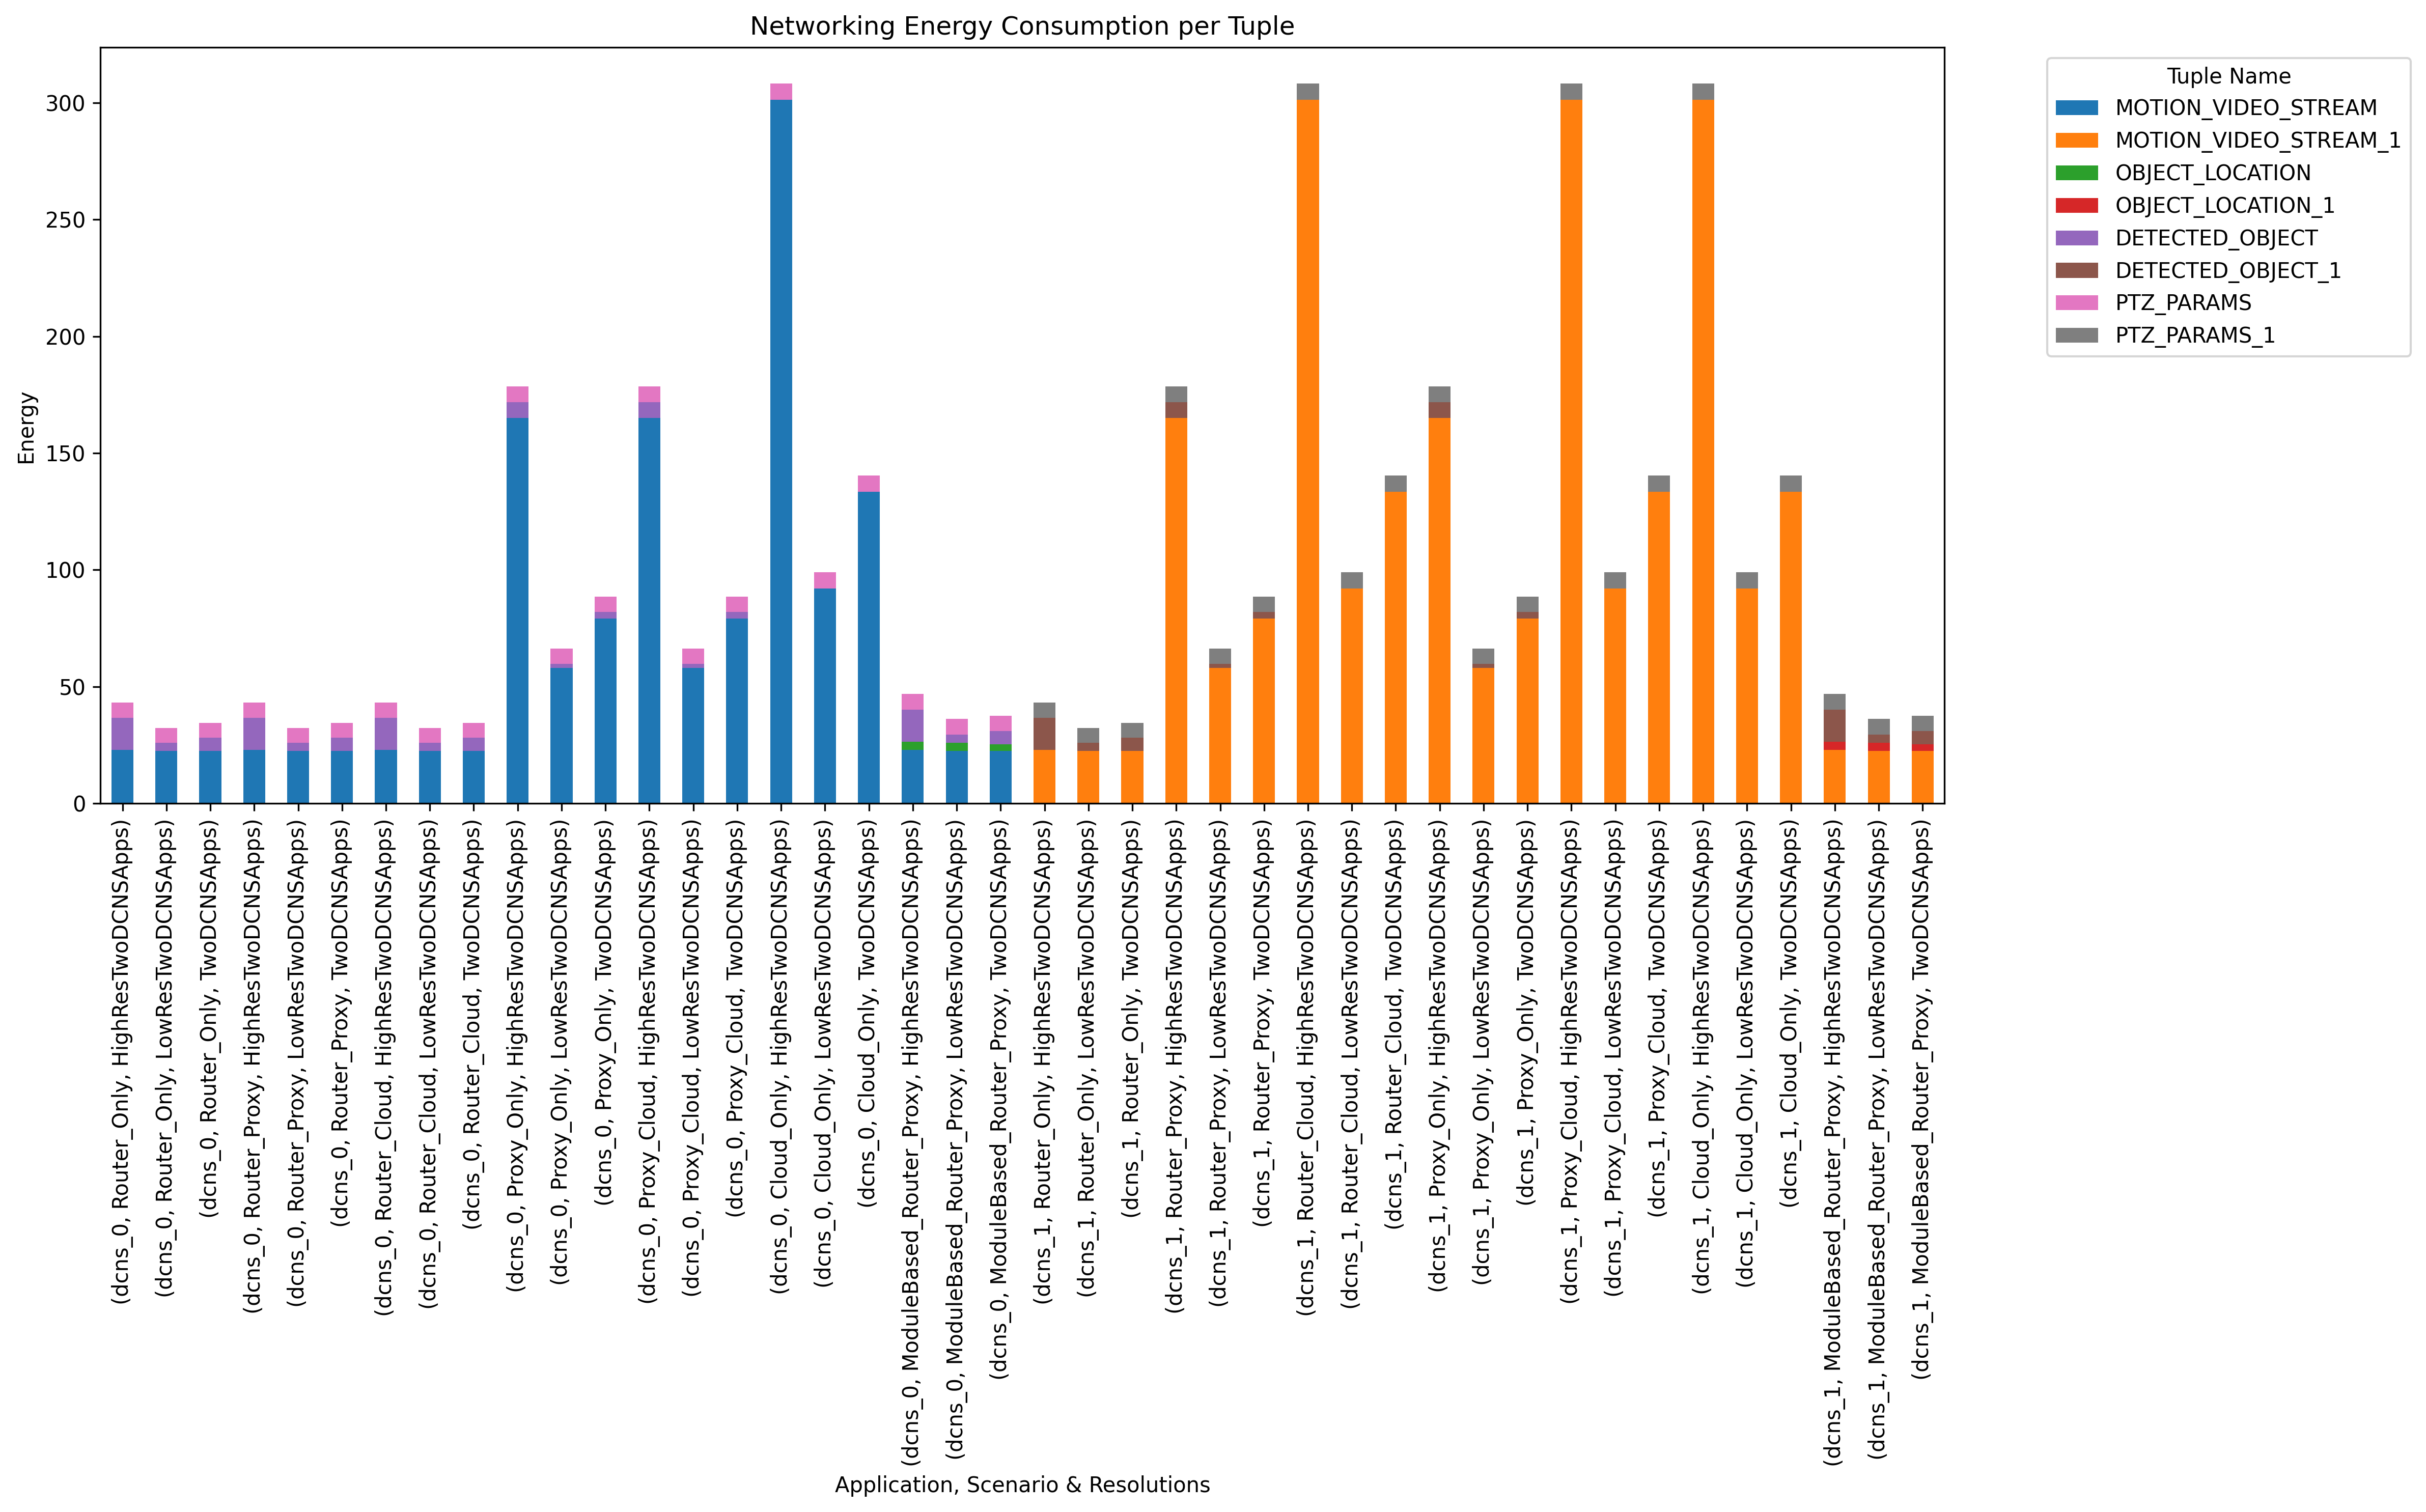

In [20]:
# Comunication energy for twodcns
t=communication_energy_df
#display(t)
#t=t.query("app=='dcns_0'")
#t['energy']=t['energy']/1000

#print(t.query("scenario == 'Cloud_Only' and app=='dcns_1'"))

pivot_df = t.pivot_table(index=['app','scenario','app_class'],columns=['tuple'],values='energy',aggfunc='sum')
pivot_df=pivot_df.reindex(columns=['MOTION_VIDEO_STREAM','MOTION_VIDEO_STREAM_1','OBJECT_LOCATION','OBJECT_LOCATION_1','DETECTED_OBJECT','DETECTED_OBJECT_1','PTZ_PARAMS','PTZ_PARAMS_1'])
#display(pivot_df)
pivot_df.to_csv('inobebin.csv')
# Plotting
ax=pivot_df.plot(kind='bar', stacked=True, figsize=(16, 10))
# Customize appearance
ax.set_title("Networking Energy Consumption per Tuple")
ax.set_xlabel("Application, Scenario & Resolutions")
ax.set_ylabel("Energy")
ax.legend(title='Tuple Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
plt.savefig('Report_Saeedeh/Pandas/App_Tuples_Communication_Energy_Chart_Fig.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

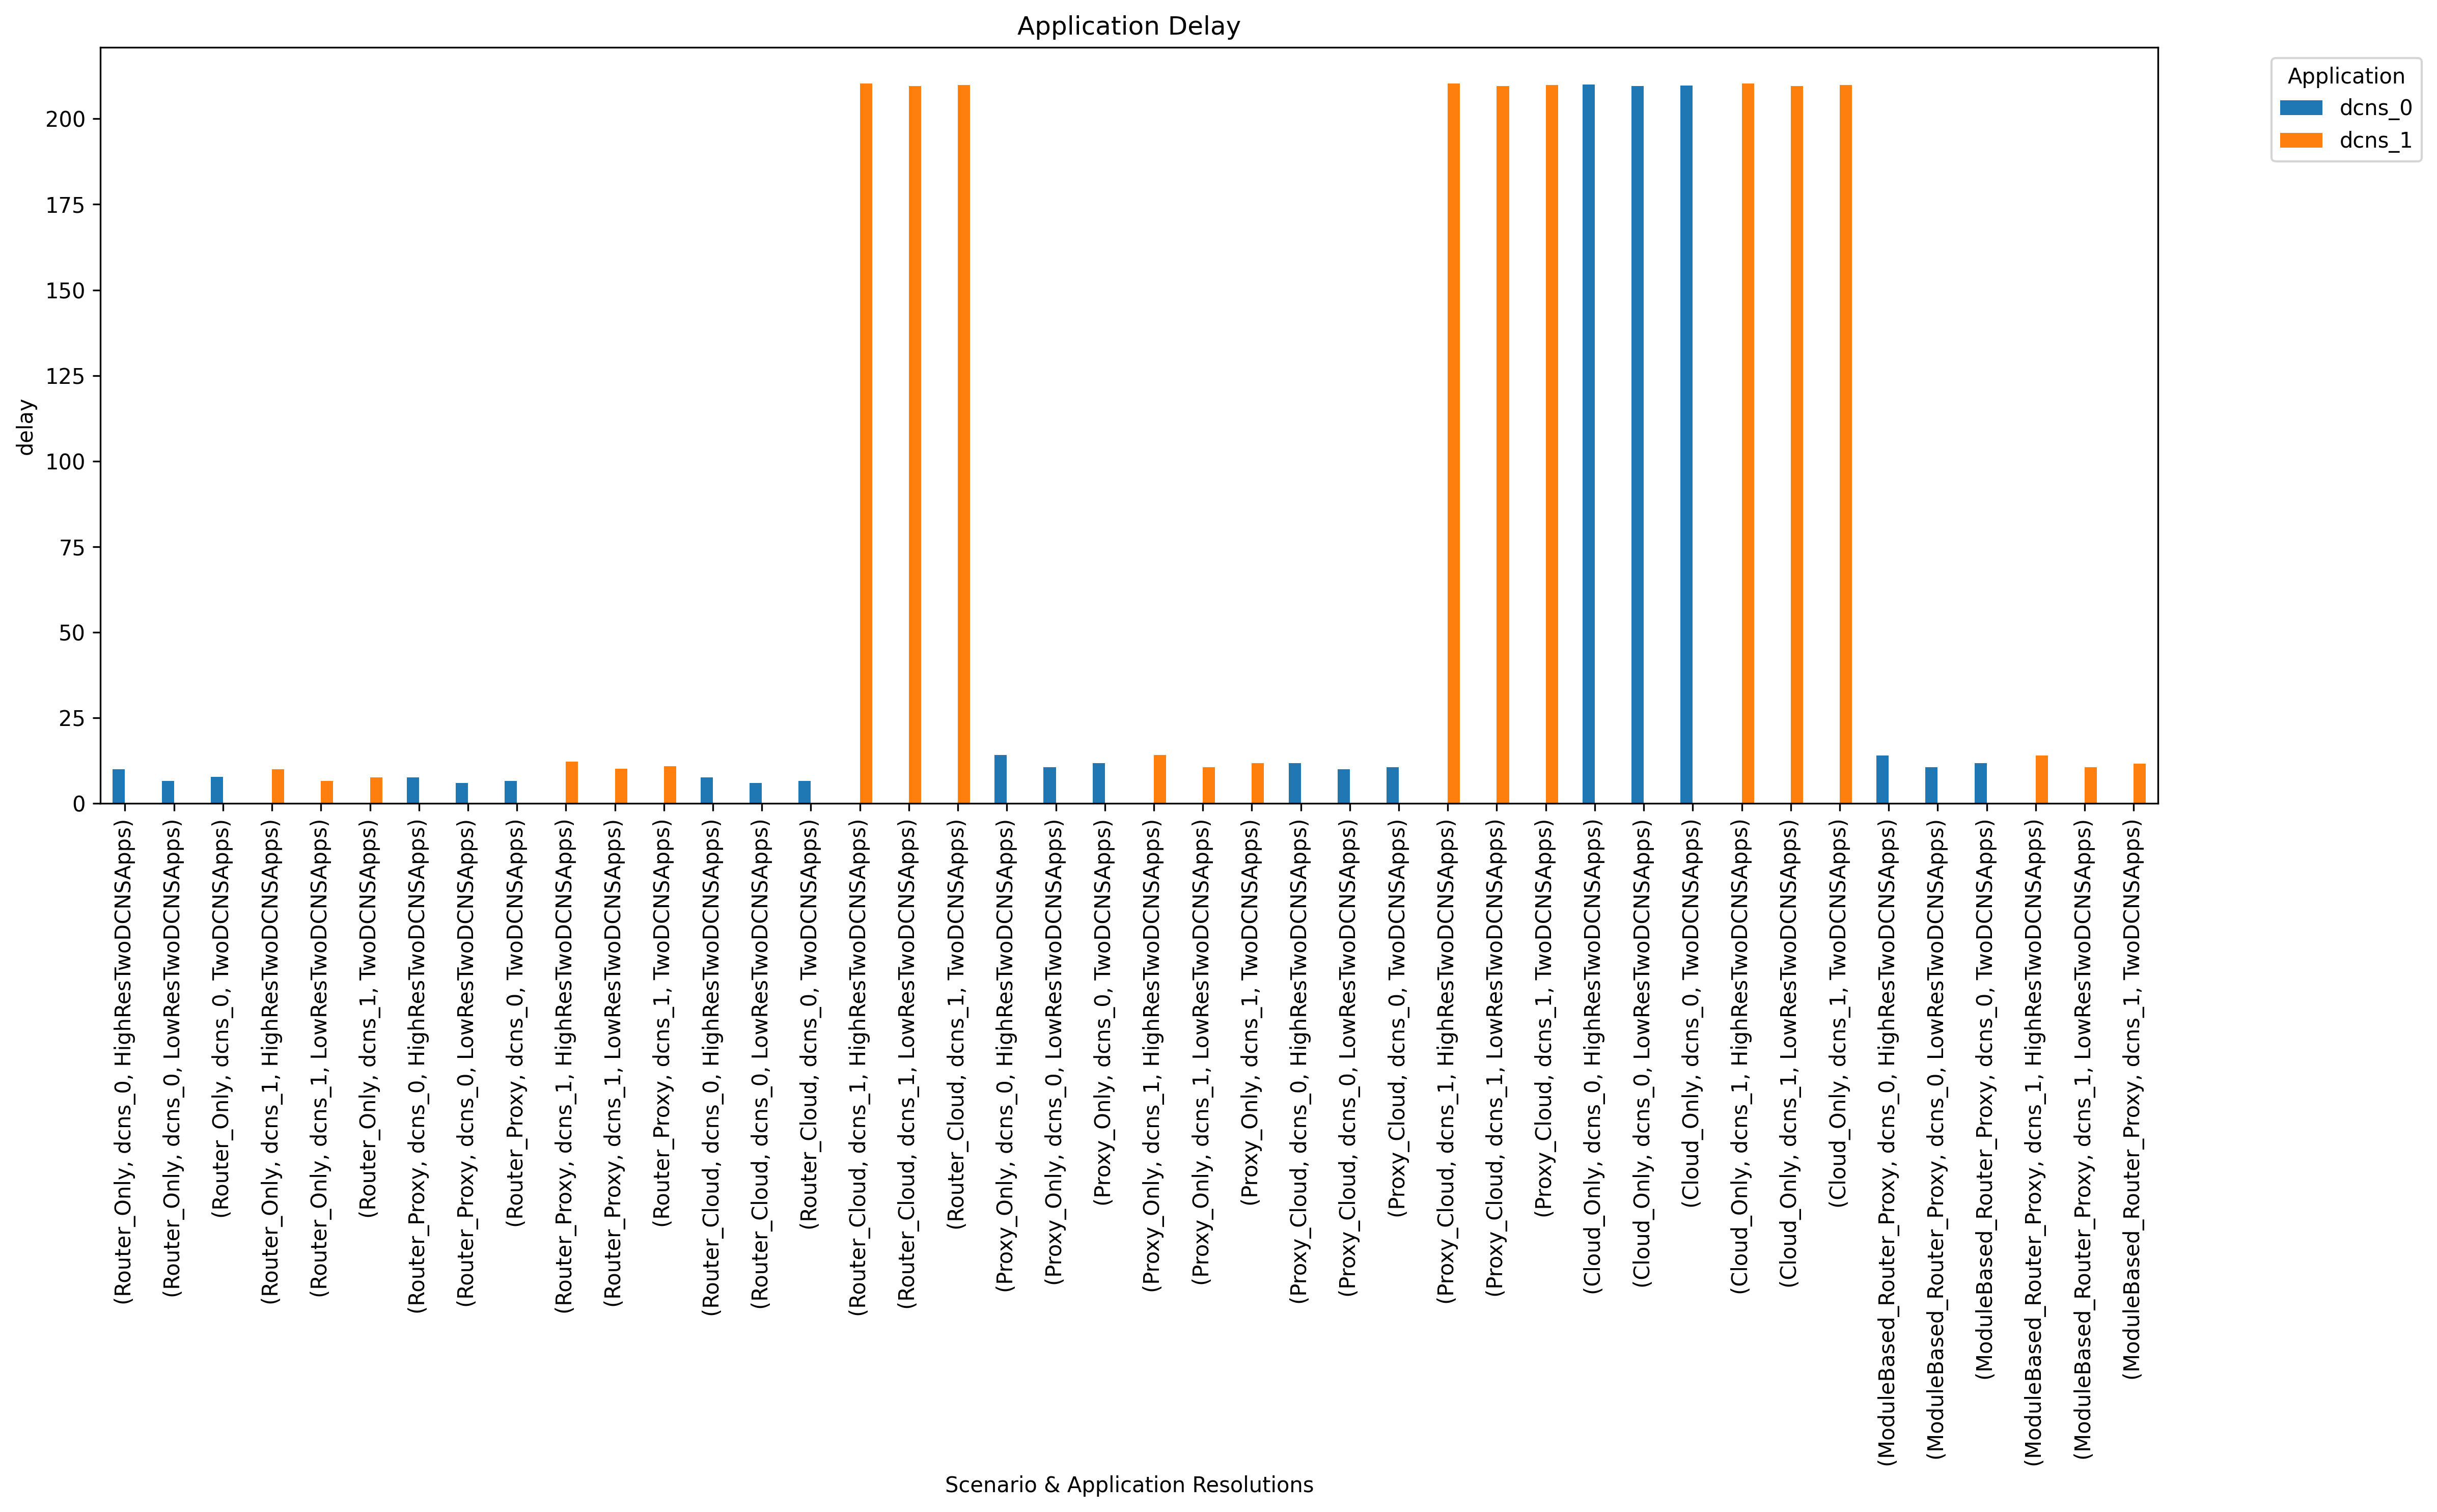

In [21]:

#VM app delays time for all resolutions(figure edge2024)
t=loop_delay_df
#t=t.query("app=='dcns_0'")
#t=t.query("scenario =='Router_Only'")


# Now create the pivot table
#print(t.query("scenario == 'Router_Only'"))

pivot_df = t.pivot_table(index=['scenario','app', 'app_class'],columns=['app'],values='delay',aggfunc='sum')
#display(pivot_df)
# Plotting
ax=pivot_df.plot(kind='bar', figsize=(16, 10))
# Customize appearance
ax.set_title("Application Delay")
ax.set_xlabel("Scenario & Application Resolutions")
ax.set_ylabel("delay")
ax.legend(title='Application', bbox_to_anchor=(1.05, 1), loc='upper left')



# Adjust layout
plt.tight_layout()


plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
plt.savefig('Report_Saeedeh/Pandas/AppDelays_Chart_Fig.pdf', format='pdf', bbox_inches='tight')


# Show plot
plt.show()

In [22]:
'''run_command="/opt/jdk-14/bin/java -Dfile.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/out/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/json-simple-1.1.1.jar org.fog.test.perfeval."
_app_name="HighResDCNS"
_report_path="Report_Saeedeh/t_resolutions_pandas.txt"
_save_path="Report_Saeedeh/Pandas"

run("HighResDCNS")
with open(_report_path, 'r') as file:
    for l in file:
        parse_Loop_Count_Delay(l)

t=loop_count_delay_df
display(t)

pivot_df = t.pivot_table(index=['resolution'],columns=['loop_count'],values='loop_count')
display(pivot_df)'''

'run_command="/opt/jdk-14/bin/java -Dfile.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/out/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/iFogSim/jars/json-simple-1.1.1.jar org.fog.test.perfeval."\n_app_name="HighResDCNS"\n_report_path="Report_Saeedeh/t_resolutions_pandas.txt"\n_save_path="Report_Saeedeh/Pandas"\n\nrun("HighResDCNS")\nwith open(_report_path, \'r\') as file:\n    for l in file

In [23]:
'''# resolution variation
t = loop_count_delay_df
t = t.query("Resolution == 1.5")
pivot_df = t.pivot_table(index='loop_count', values='loop_delay')  # Use 'loop_delay' as values
print(pivot_df.dtypes)
display(pivot_df)
# Plotting the pivot table
pivot_df.plot(figsize=(12, 8))

 # Adding labels and title
plt.title('Loop Delay Variation by Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loop Delay')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.tight_layout()
plt.show()'''

'# resolution variation\nt = loop_count_delay_df\nt = t.query("Resolution == 1.5")\npivot_df = t.pivot_table(index=\'loop_count\', values=\'loop_delay\')  # Use \'loop_delay\' as values\nprint(pivot_df.dtypes)\ndisplay(pivot_df)\n# Plotting the pivot table\npivot_df.plot(figsize=(12, 8))\n\n # Adding labels and title\nplt.title(\'Loop Delay Variation by Iteration\')\nplt.xlabel(\'Iteration\')\nplt.ylabel(\'Loop Delay\')\n\n# Rotating x-axis labels for better readability\nplt.xticks(rotation=45)\n\n# Displaying the plot\nplt.tight_layout()\nplt.show()'

In [24]:
'''t=loop_count_delay_df
pivot_df = t.pivot_table(index='Resolution', values='loop_delay',aggfunc='max')  # Use 'loop_delay' as values
display(pivot_df)
# Plotting the pivot table
pivot_df.plot(figsize=(12, 8))

 # Adding labels and title
plt.title('Loop Delay Variation by Iteration')
plt.xlabel('Resolution')
plt.ylabel('AVG Loop Delay')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

#plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)
# Save the figure as a PDF
#plt.savefig('Report_Saeedeh/Pandas/Avg_loop_delay_different_res_Chart_Fig.pdf', format='pdf', bbox_inches='tight')

# Displaying the plot
plt.tight_layout()
plt.show()'''

"t=loop_count_delay_df\npivot_df = t.pivot_table(index='Resolution', values='loop_delay',aggfunc='max')  # Use 'loop_delay' as values\ndisplay(pivot_df)\n# Plotting the pivot table\npivot_df.plot(figsize=(12, 8))\n\n # Adding labels and title\nplt.title('Loop Delay Variation by Iteration')\nplt.xlabel('Resolution')\nplt.ylabel('AVG Loop Delay')\n\n# Rotating x-axis labels for better readability\nplt.xticks(rotation=45)\n\n#plt.rcParams['figure.dpi'] = 300  # Adjust DPI for better quality (optional)\n# Save the figure as a PDF\n#plt.savefig('Report_Saeedeh/Pandas/Avg_loop_delay_different_res_Chart_Fig.pdf', format='pdf', bbox_inches='tight')\n\n# Displaying the plot\nplt.tight_layout()\nplt.show()"